# Reproducing Mapping Gaussian Process Priors to Bayesian Neural Networks

**Objective**: Specify more expressive, well-suited BNN priors by approximating existing GP priors.
- GP do not scale well to large data settings, but kernel design techniques are well-studied
- BNN are not limited by the size of the dataset, but specifying an interesting prior is not straightforward
- There are strong connections between the 2 models, and BNN become equivalent to GP in the limit (when increasing width, for a shallow network), in some cases (e.g. Gaussian prior on the weights) [Neal, 1996](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.446.9306&rep=rep1&type=pdf)

_Graphical model of a BNN:_

<img src="img/bnn.png" style="width: 200px;"/>

**Prior optimization**
A commonly used prior for BNN is to consider iid weights, following a Gaussian distribution or a mixture of Gaussians (cf Bayes By Backprop paper [Blundell, Charles, et al, 2015](https://arxiv.org/pdf/1505.05424.pdf), BNN library [blitz](https://github.com/piEsposito/blitz-bayesian-deep-learning) on github ).
$$
\forall i, w_i \sim \pi \mathcal{N}(0, \sigma_1) + (1-\pi) \mathcal{N}(0, \sigma_2)
$$
with $\sigma_1 >> \sigma_2$

The [Mapping Gaussian Process Priors to Bayesian Neural Networks](http://bayesiandeeplearning.org/2017/papers/65.pdf) paper considers a more expressive prior with 2 vectors of parameters $\mu_\phi, \sigma_\phi$ such that weights are still independant, but not identically distributed:
$$
\forall i, w_i \sim \mathcal{N}(\mu_\phi^i, \sigma_\phi^i)
$$

And prior parameters $\mu_\phi, \sigma_\phi$ are optimized to match a specific GP prior, by minimizing the KL divergence between the 2 distributions.

$$
\begin{aligned}
\mathbb{K} \mathbb{L}\left[p_{\mathrm{BNN}}(\boldsymbol{f} \mid \boldsymbol{\phi}) \mid p_{\mathrm{GP}}(\boldsymbol{f})\right]
&=\int p_{\mathrm{BNN}}(\boldsymbol{f} \mid \boldsymbol{\phi}) \log \left[\frac{p_{\mathrm{BNN}}(\boldsymbol{f} \mid \boldsymbol{\phi})}{p_{\mathrm{GP}}(\boldsymbol{f})}\right] d \boldsymbol{f} \\
&=-\mathbb{H}\left[p_{\mathrm{BNN}}(\boldsymbol{f} \mid \boldsymbol{\phi})\right]-\mathbb{E}_{p_{\mathrm{BNN}}(\boldsymbol{f} \mid \phi)}\left[\log p_{\mathrm{GP}}(\boldsymbol{f})\right]
\end{aligned}
$$

Taking expectation over the input data:
$$
\begin{aligned}
\mathcal{L}_{\mathbf{X}}(\boldsymbol{\phi})
&=-\mathbb{E}_{\mathbf{X} \sim p(\mathbf{X})} \mathbb{H}\left[p_{\mathrm{BNN}}(\boldsymbol{f}(\mathbf{X}) \mid \boldsymbol{\phi})\right]-\mathbb{E}_{\mathbf{X} \sim p(\mathbf{X})} \mathbb{E}_{p_{\mathrm{BNN}}(\boldsymbol{f}(\mathbf{X}) \mid \boldsymbol{\phi})}\left[\log p_{\mathrm{GP}}(\boldsymbol{f}(\mathbf{X}))\right]
\end{aligned}
$$

In practice, they ignore the entropy term, and use a MC estimate for the log likelihood term:
$$
\begin{aligned}
\mathcal{L}_{\mathbf{X}}(\boldsymbol{\phi})
&\approx \frac{1}{S} \sum_{s=1}^{S} \mathbb{E}\left[\log p_{\mathrm{GP}}\left(\boldsymbol{f}^{(s)}(\mathbf{X})\right)\right]
\end{aligned}
$$

In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader

import sys
sys.path.append('../src/')
from datasets import get_toy_data
from figures import plot_deciles, plot_prior, plot_posterior
from models import BayesianMLP
from train_inference import train, eval_1d_regression

# create dataset
x_train, y_train, x_val, y_val, x_all, y_all = get_toy_data(
    num_samples=70, sigma=0.1
)
dataloader_train = DataLoader(
    TensorDataset(x_train, y_train), batch_size=70, shuffle=True
)

## Comparing different priors

### BNN - no activation function

In [2]:
dim_h = 20
n_layers = 2
activation = "nothing"

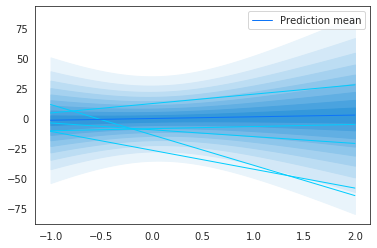

In [3]:
# default prior
model = BayesianMLP(
    dim_in=1,
    dim_out=1,
    dim_h=dim_h,
    n_layers=n_layers,
    prior_type="normal",
    posterior_rho_init=-3.,
    prior_sigma=1.,
    activation=activation,
)
plot_prior(model, x_all)

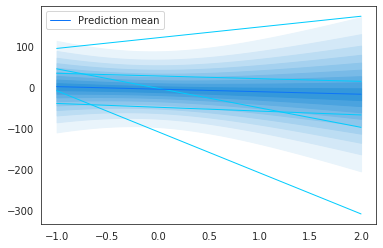

In [4]:
# mixture prior
model = BayesianMLP(
    dim_in=1,
    dim_out=1,
    dim_h=dim_h,
    n_layers=n_layers,
    prior_type="mixture",
    # prior_sigma=prior_sigma,
    prior_pi=0.5,
    prior_sigma_1=2.,
    prior_sigma_2=0.01,
    posterior_rho_init=-3.,
    activation=activation,
)
plot_prior(model, x_all)

### BNN - ReLU activation

In [5]:
dim_h = 20
n_layers = 2
activation = "relu"

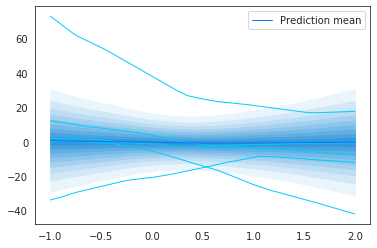

In [6]:
# default prior
model = BayesianMLP(
    dim_in=1,
    dim_out=1,
    dim_h=dim_h,
    n_layers=n_layers,
    prior_type="normal",
    posterior_rho_init=-3.,
    prior_sigma=1.,
    activation=activation,
)
plot_prior(model, x_all)

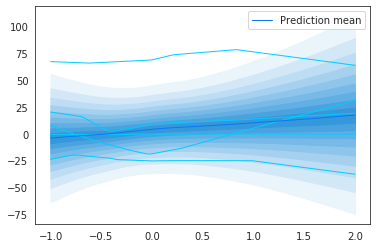

In [7]:
# mixture prior
model = BayesianMLP(
    dim_in=1,
    dim_out=1,
    dim_h=dim_h,
    n_layers=n_layers,
    prior_type="mixture",
    # prior_sigma=prior_sigma,
    prior_pi=0.5,
    prior_sigma_1=2.,
    prior_sigma_2=0.01,
    posterior_rho_init=-3.,
    activation=activation,
)
plot_prior(model, x_all)

### BNN & GP - Linear Activation & Linear Kernel
```
gp: Gaussian Process
gpp: BNN with optimized prior to match GP
bnn: BNN with default N(0,1) prior
```

<img src="../figures/prior with kernel = Linear Kernel activation = linear-prior.png" width="600">

### BNN & GP - RBF activation (and RBF kernel)

In [8]:
dim_h = 20
n_layers = 2
activation = "rbf"

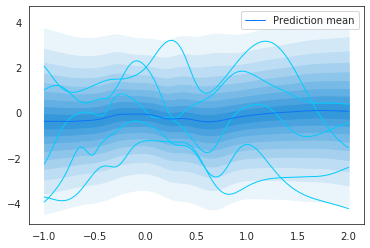

In [9]:
# default prior
model = BayesianMLP(
    dim_in=1,
    dim_out=1,
    dim_h=dim_h,
    n_layers=n_layers,
    prior_type="normal",
    posterior_rho_init=-3.,
    prior_sigma=1.,
    activation=activation,
)
plot_prior(model, x_all)

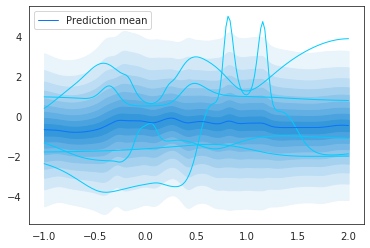

In [10]:
# mixture prior
model = BayesianMLP(
    dim_in=1,
    dim_out=1,
    dim_h=dim_h,
    n_layers=n_layers,
    prior_type="mixture",
    # prior_sigma=prior_sigma,
    prior_pi=0.5,
    prior_sigma_1=2.,
    prior_sigma_2=0.01,
    posterior_rho_init=-3.,
    activation=activation,
)
plot_prior(model, x_all)

```
gp: Gaussian Process
gpp: BNN with optimized prior to match GP
bnn: BNN with default N(0,1) prior
```

_GP and BNN with optimized prior, RBF kernel & RBF activation_
<img src="../figures/prior with kernel = Gaussian Kernel 2 activation = rbf-prior.png" width="600">

_GP and BNN with optimized prior, RQ kernel & RBF activation_
<img src="../figures/prior with kernel = RQ Kernel activation = rbf-prior.png" width="600">

### BNN - Softplus activation

In [11]:
dim_h = 20
n_layers = 2
activation = "softplus"

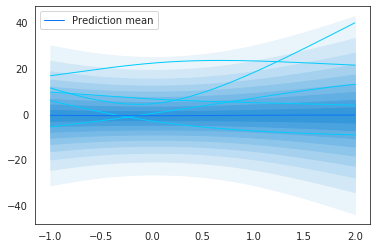

In [12]:
# default prior
model = BayesianMLP(
    dim_in=1,
    dim_out=1,
    dim_h=dim_h,
    n_layers=n_layers,
    prior_type="normal",
    posterior_rho_init=-3.,
    prior_sigma=1.,
    activation=activation,
)
plot_prior(model, x_all)

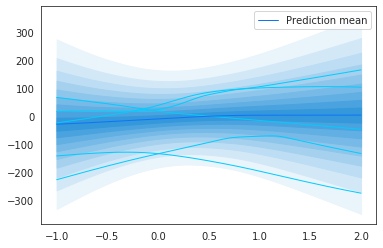

In [13]:
# mixture prior
model = BayesianMLP(
    dim_in=1,
    dim_out=1,
    dim_h=dim_h,
    n_layers=n_layers,
    prior_type="mixture",
    # prior_sigma=prior_sigma,
    prior_pi=0.5,
    prior_sigma_1=3.,
    prior_sigma_2=0.01,
    posterior_rho_init=-3.,
    activation=activation,
)
plot_prior(model, x_all)

### BNN & GP - Tanh Activation and RBF kernel
<img src="../figures/prior with kernel = Gaussian Kernel 50 activation = tanh-prior.png" width="600">


### BNN & GP - Sinus Activation and Periodic Kernel
<img src="../figures/prior with kernel = Periodic Kernel 25 activation = sinus-prior.png" width="600">

## Regression task in small dimension

### BNN - ReLU activation

MSE (train - mean of 30 BNN samples): 0.060688987374305725


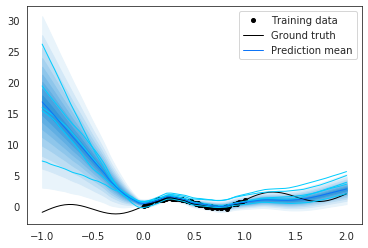

In [14]:
# mixture prior
model = BayesianMLP(
    dim_in=1,
    dim_out=1,
    dim_h=512,
    n_layers=1,
    prior_type="mixture",
    prior_pi=0.45,
    prior_sigma_1=0.01, 
    prior_sigma_2=1.17,
    posterior_rho_init=-3.77,
    activation="relu",
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
model = train(
        model,
        optimizer,
        dataloader_train,
        n_epochs=150,
        evaluate_func=eval_1d_regression,
        evaluate_data=(x_train, y_train, x_val, y_val, x_all, y_all, 20),
        model_noise_var=1.,
        M=70,
)
plot_posterior(model, x_all, y_all, x_train, y_train)

### BNN - RBF activation

MSE (train - mean of 30 BNN samples): 0.012608926743268967


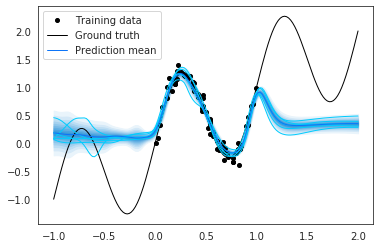

In [15]:
# mixture prior
model = BayesianMLP(
    dim_in=1,
    dim_out=1,
    dim_h=20,
    n_layers=2,
    prior_type="mixture",
    prior_pi=0.801,
    prior_sigma_1=0.083,
    prior_sigma_2=8.247,
    posterior_rho_init=-3.77,
    activation="rbf",
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
model = train(
        model,
        optimizer,
        dataloader_train,
        n_epochs=150,
        evaluate_func=eval_1d_regression,
        evaluate_data=(x_train, y_train, x_val, y_val, x_all, y_all, 20),
        model_noise_var=1.,
        M=70,
)
plot_posterior(model, x_all, y_all, x_train, y_train)

### GP - RBF kernel

With $f(x) = x sin(x) / 10$:

<img src="../figures/regression results on periodic_linear_deciles.png" width="500">

With $f(x) = e^{-x^{2} / 2}$:

<img src="../figures/regression results on exponential_deciles.png" width="500">

With $f(x) = sin(2 \pi x) + x$:

<img src="../figures/regression results on periodic_deciles.png" width="500">

### Comparison, f(x) = exp(x^2/2)

**BNN architecture:** 2 hidden layers, dim_h=20

BNN, default prior $N(0, 1)$:

<img src="../figures/regression results on plain bnn On exponential function_deciles.png" width="600">

GP, RBF kernel:

<img src="../figures/regression results on exponential_deciles.png" width="600">

BNN, optimized prior

<img src="../figures/regression results on bnn with optimized prior On exponential function_deciles.png" width="600">

## Hyper-parameter optimisation
Before doing a larger scale-up study, we wanted to make sure the models were able to learn on simple tasks (1d regression).

This proved way more difficult than expected, and finding the right architecture and hyperparameters was a challenge, even on the simple 1d regression task.

Variational inference using the Bayes By Backprop algorithm proved to be very sensitive to a number of choices:
- network architecture: convergence was harder with 2 layers than 1 layer
- activation function: this leads to very different priors, naturally ([Pearce, Tim, et al., 2020](http://proceedings.mlr.press/v115/pearce20a/pearce20a.pdf) even uses combinations of activation functions as a way to specify BNN priors)
- prior parameters $\sigma_1, \sigma_2, \pi$
- **BNN weight initialisation**:
    - we first tried initializing BNN variation posterior weights to match the prior, but this made training significantly more difficult (
    - we then tried another initialization as advised [here](https://gluon.mxnet.io/chapter18_variational-methods-and-uncertainty/bayes-by-backprop.html), with $\mu_\theta \sim \mathcal{N}(0,1), \rho_\theta = -5$
    - we also experimented with $\mu_\theta \sim \mathcal{N}(\mu_{init},0.1), \rho_\theta \sim \mathcal{N}(\rho_{init},0.1)$
    - [Rossi, Simone et al, 2019](https://arxiv.org/pdf/1810.08083.pdf) studies the impact of various initialization techniques

<img src="img/bnn-collapse.png" width="300px">
<img src="img/bnn-not-learning.png" width="300px">

To accelerate the search, we used the [optuna](https://optuna.readthedocs.io/en/stable/) hyperparameter optimisation framework.

<img src="img/optuna2.png" width="600px">

<img src="img/optuna.png" width="600px">

## Conclusion :
The proposed method, in fact, allowed a more flexible way of defining more expressive BNNs by specifying the prior directly on the function space. However, this method suffers from some drawbacks:
* There are limitations to this method, we can only map properties of GP priors to BNNs with configurations that could reasonably learn those properties. For example, it is not possible to map the properties of a GP prior with a periodic kernel to a BNN that doesn't have a periodic activation function.
* No efficient estimator of the entropy term which acts as a regularizer. This leaves no choice than to perform early stoping. We observe that at the beginning of the prior optimisation, samples from the optimized BNN prior would take on the properties of the GP prior then gradually flatten and lose the desired properties. This makes the prior optimisation a rather complicated task.

### Reproducing Results :
* To reproduce the GP regression results, run test_GP_reg_1D.py.
* To reproduce the prior optimisation results, run test_map_gpp_bnnp.py.

### Experiments notes:

- N(0, sigma) prior (using my implementation of the prior and the posterior): studies `study_20210405_195311` and `study_20210405_200241` for hyper param studies (resp. TPE and random search), not successful. Study `study_20210406_203900` tries with complexity_cost=2^M-ep/2^M-1
- mixture of gaussians: 
    - initializing to match prior ("uninformative initialization"): fails, study `study_20210406_220210`
    - using random initialization from blitz, with default rho/mu init variance and dim_h=20, 2 layers: 
        - study `study_20210406_214519` (learning sigma1, sigma2, pi, model_noise), 
        - study `study_20210406_215017` (learning sigma1, sigma2, pi, model_noise=1.), 
        - study `study_20210406_215329` (learning sigma1, sigma2=1., pi=1., model_noise=1.) 
        - all are able to learn sine curves, but the uncertainty estimate is completely wrong (way too small)
    - using random init from blitz with default rho/mu (actually using blitz modules), but dim_h=512, relu, 1 hidden layer:
        - `study_20210408_091755`: good accuracy, but no stochasticity
        - `study_20210408_094404` with no early stopping and random search for more diversity
        - easier to learn, but uncertainty estimate still wrong
        - `study_20210408_095348`: trying with M=1 instead of M=70, to increase the role of the KL. Trial 2 ok !! (prior_pi=0.45, prior_sigma_1=0.01, prior_sigma_2=1.17) after ~300ep, but still unstable
    - back to rbf:
        - `study_20210408_193346`: fails (init seems wrong)
        - `study_20210408_194718`: try optimising/changing posterior_rho/mu_init as well, not much success
    - back to our implementation, with authors initialisation (random mu, fixed scale), rbf:
        - `study_20210408_202723`: 2 layers, h_dim=20, random scale parameter, seems better sometimes (trial 3: 'prior_sigma_1': 0.08324599639781513, 'prior_sigma_2': 8.246627085231355, 'prior_pi': 0.801549960333397, 'posterior_rho_init': -3.772311600494804)
        - `study_20210408_204449` 1 layer, h_dim=512